In [33]:
# Basic system and audio processing
import os, wave, pickle, warnings
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import pyaudio
import noisereduce as nr
from scipy.fftpack import dct
from tqdm import tqdm
# Machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore unnecessary warnings
warnings.filterwarnings("ignore")


In [34]:
# Mapping class indices to their labels
class_labels = {
    0: "belly_pain",
    1: "burping",
    2: "discomfort",
    3: "hungry",
    4: "tired"
}


In [35]:
# Extract MFCC features from a .wav audio file
def extract_mfcc(audio_file_path, sample_rate=None, pre_emphasis=0.97, frame_size=0.025, frame_stride=0.01,
                 NFFT=512, nfilt=40, num_ceps=12, fixed_length=100):
    y, sr = librosa.load(audio_file_path, sr=sample_rate)
    
    # Pre-emphasis to amplify high frequencies
    emphasized_signal = np.append(y[0], y[1:] - pre_emphasis * y[:-1])
    
    # Framing
    frame_length, frame_step = int(round(frame_size * sr)), int(round(frame_stride * sr))
    signal_length = len(emphasized_signal)
    num_frames = int(np.ceil((np.abs(signal_length - frame_length)) / frame_step))
    
    # Padding signal
    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros(pad_signal_length - signal_length)
    pad_signal = np.append(emphasized_signal, z)

    # Framing into windows
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    frames *= np.hamming(frame_length)  # Apply Hamming window

    # FFT and Power Spectrum
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
    pow_frames = (1.0 / NFFT) * (mag_frames ** 2)

    # Mel Filterbank
    mel_points = np.linspace(0, 2595 * np.log10(1 + (sr / 2) / 700), nfilt + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    bin = np.floor((NFFT + 1) * hz_points / sr)
    
    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus, f_m, f_m_plus = int(bin[m - 1]), int(bin[m]), int(bin[m + 1])
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)

    # MFCC using DCT
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1:(num_ceps + 1)]

    # Normalize to fixed size
    if mfcc.shape[0] < fixed_length:
        pad_width = fixed_length - mfcc.shape[0]
        mfcc = np.pad(mfcc, pad_width=((0, pad_width), (0, 0)), mode='constant')
    else:
        mfcc = mfcc[:fixed_length]
    
    return mfcc


In [36]:
# Apply MFCC extraction for all subfolders (cry types)
def extract_mfcc_for_folders(data_folder, subfolders, **kwargs):
    features, labels = [], []
    for label, subfolder in enumerate(subfolders):
        folder_path = os.path.join(data_folder, subfolder)
        files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]

        print(f"Processing {subfolder}:")
        for filename in tqdm(files, desc=f"{subfolder}", unit="file"):
            file_path = os.path.join(folder_path, filename)
            mfccs = extract_mfcc(file_path, **kwargs)
            features.append(mfccs.flatten())
            labels.append(label)
    return np.array(features), np.array(labels)


In [37]:
# Define training dataset path and subfolders
data_folder = os.path.abspath("../audio_dataset/augment_audio_cry")
# data_folder = "audio_dataset/augment_audio_cry"
subfolders = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']



# Extract features and labels
features, labels = extract_mfcc_for_folders(data_folder, subfolders, fixed_length=100)

# Save MFCC features to CSV
df = pd.DataFrame(features)
df['label'] = labels
df.to_csv("mfcc_features.csv", index=False)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.15, random_state=62)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model training
forest_model = RandomForestClassifier(n_estimators=200, random_state=50, criterion="entropy", max_depth=32, class_weight="balanced")
forest_model.fit(X_train_scaled, y_train)


Processing belly_pain:


belly_pain: 100%|██████████| 27/27 [00:00<00:00, 104.44file/s]


Processing burping:


burping: 100%|██████████| 27/27 [00:00<00:00, 107.37file/s]


Processing discomfort:


discomfort: 100%|██████████| 27/27 [00:00<00:00, 108.41file/s]


Processing hungry:


hungry: 100%|██████████| 27/27 [00:00<00:00, 44.61file/s]


Processing tired:


tired: 100%|██████████| 27/27 [00:00<00:00, 105.25file/s]


,n_estimators,200
,criterion,'entropy'
,max_depth,32
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [38]:
# Save trained model and scaler for future predictions
with open("Forest_model.pkl", "wb") as f:
    pickle.dump(forest_model, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


Accuracy: 0.9047619047619048
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6
           2       1.00      0.33      0.50         3
           3       1.00      1.00      1.00         6
           4       0.50      1.00      0.67         2

    accuracy                           0.90        21
   macro avg       0.90      0.87      0.83        21
weighted avg       0.95      0.90      0.90        21



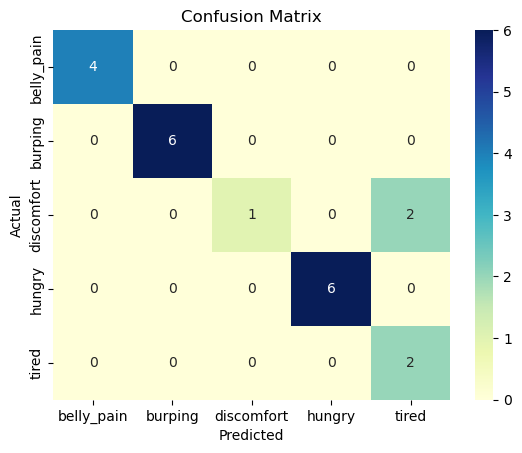

In [39]:
# Prediction on test set
y_pred = forest_model.predict(X_test_scaled)

# Accuracy and report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix visualization
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="YlGnBu", xticklabels=subfolders, yticklabels=subfolders)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [40]:
def record_audio(filename, duration=7, sr=44100):
    chunk = 1024
    format = pyaudio.paInt16
    channels = 1
    p = pyaudio.PyAudio()
    print("Recording...")
    stream = p.open(format=format, channels=channels, rate=sr, input=True, frames_per_buffer=chunk)
    frames = [stream.read(chunk) for _ in range(0, int(sr / chunk * duration))]
    print("Finished recording.")
    stream.stop_stream(); stream.close(); p.terminate()
    
    # Save raw audio
    wf = wave.open(filename, 'wb')
    wf.setnchannels(channels); wf.setsampwidth(p.get_sample_size(format))
    wf.setframerate(sr); wf.writeframes(b''.join(frames)); wf.close()

def clean_audio(audio_file_path):
    y, sr = librosa.load(audio_file_path, sr=None)
    y_denoised = nr.reduce_noise(y=y, sr=sr)
    y_trimmed, _ = librosa.effects.trim(y_denoised, top_db=20)
    return y_trimmed, sr

def plot_waveform(signal, sr):
    plt.figure(figsize=(10, 4))
    plt.plot(np.linspace(0, len(signal) / sr, num=len(signal)), signal)
    plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.title('Waveform')
    plt.show()


In [41]:
def predict_with_probabilities(audio_features, model, scaler):
    features_flatten = audio_features.flatten()
    required_features = 1200  # 100 MFCC frames × 12 coefficients
    repeat_times = required_features // len(features_flatten) + 1
    extended_features = np.tile(features_flatten, repeat_times)[:required_features]
    extended_features = scaler.transform([extended_features])
    probabilities = model.predict_proba(extended_features)[0]
    return probabilities


In [42]:
def process_audio(filename):
    record_audio(filename)
    cleaned_signal, sr = clean_audio(filename)
    plot_waveform(cleaned_signal, sr)
    sf.write("cleaned_temp.wav", cleaned_signal, sr)

    mfcc_features = extract_mfcc("cleaned_temp.wav")

    with open("Forest_model.pkl", "rb") as f:
        model = pickle.load(f)
    with open("scaler.pkl", "rb") as f:
        scaler = pickle.load(f)

    probabilities = predict_with_probabilities(mfcc_features, model, scaler)
    sorted_indices = np.argsort(probabilities)[::-1]

    print("\nPrediction probabilities:")
    for idx in sorted_indices:
        print(f"{class_labels[idx]}: {probabilities[idx]*100:.2f}%")
    
    print(f"\nMost likely prediction: {class_labels[sorted_indices[0]]}")


Recording...
Finished recording.


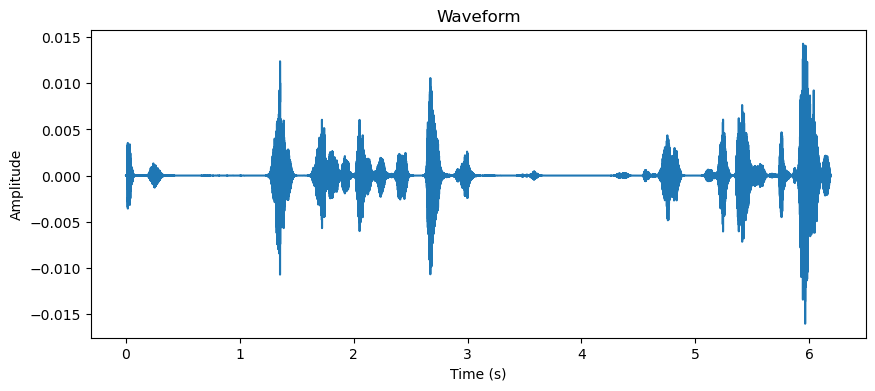


Prediction probabilities:
hungry: 31.00%
tired: 21.00%
belly_pain: 18.50%
discomfort: 17.63%
burping: 11.87%

Most likely prediction: hungry


In [43]:
# Trigger the full pipeline (record, process, predict)
process_audio("recorded_audio.wav")


In [44]:
# %%
# Predict all files inside data_for_prediction subfolders
def predict_files_in_folder(prediction_root="data_for_prediction"):
    # Load model and scaler
    with open("Forest_model.pkl", "rb") as f:
        model = pickle.load(f)
    with open("scaler.pkl", "rb") as f:
        scaler = pickle.load(f)

    # Loop through each subfolder (cry type)
    for subfolder in os.listdir(prediction_root):
        folder_path = os.path.join(prediction_root, subfolder)
        if not os.path.isdir(folder_path):
            continue
        
        print(f"Processing files in folder: {folder_path}")
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(folder_path, file)
                try:
                    mfcc_features = extract_mfcc(file_path, fixed_length=100)
                    features_flatten = mfcc_features.flatten()

                    # Pad or trim to required size
                    required_features = 1200  # 100 frames × 12 coefficients
                    repeat_times = required_features // len(features_flatten) + 1
                    extended_features = np.tile(features_flatten, repeat_times)[:required_features]
                    scaled_features = scaler.transform([extended_features])

                    # Predict
                    prediction = model.predict(scaled_features)[0]
                    predicted_label = class_labels[prediction]

                    print(f"Predicted class for {file} is: {predicted_label}")
                except Exception as e:
                    print(f"Error processing {file}: {e}")

# Call the function
prediction_folder = os.path.abspath("../audio_dataset/data_for_prediction")
predict_files_in_folder(prediction_folder)



Processing files in folder: c:\Users\viraj\OneDrive\Desktop\Infant Cry Analysis\audio_dataset\data_for_prediction\belly_pain
Predicted class for 549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.wav is: hungry
Predicted class for 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138495-1.0-m-72-bp.wav is: hungry
Predicted class for 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138506-1.0-m-72-bp.wav is: tired
Predicted class for 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138514-1.0-m-72-bp.wav is: tired
Predicted class for 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138524-1.0-m-72-bp.wav is: belly_pain
Predicted class for 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138536-1.0-m-72-bp.wav is: belly_pain
Predicted class for 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138545-1.0-m-72-bp.wav is: tired
Predicted class for 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138591-1.0-m-72-bp.wav is: tired
Predicted class for 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138647-1.0-m-72-bp.wav is: tired
Predicted clas